In [1]:
%%capture
!pip install --upgrade albumentations==1.1.0
!echo "$(pip freeze | grep albumentations) is successfully installed"
# !pip install -U -q kaggle==1.5.8

In [2]:
from google.colab import drive
drive._mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **1. Download data from kaggle**

In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
import sys

%load_ext autoreload
%autoreload 2

In [4]:
# # Tải file kaggle.json lên
# from google.colab import files
# files.upload()

# # Tạo thư mực ~/.kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# # Download data from competitions
# !kaggle competitions download -c bkai-igh-neopolyp

# # Unzip data
# !mv bkai-igh-neopolyp.zip /content/drive/MyDrive/Neo-Unet/data

project_path = "/content/drive/MyDrive/Neo-Unet"
sys.path.append(project_path)
%cd "/content/drive/MyDrive/Neo-Unet"
!cp -r /content/drive/MyDrive/Neo-Unet/data /content/data/
!pwd

# with zipfile.ZipFile("data/bkai-igh-neopolyp.zip", 'r') as zip_ref:
#     zip_ref.extractall("data/")

/content/drive/.shortcut-targets-by-id/1BLjG0v2fB7zjj1yY7YIzN7JftczXoiJ3/Neo-Unet
/content/drive/.shortcut-targets-by-id/1BLjG0v2fB7zjj1yY7YIzN7JftczXoiJ3/Neo-Unet


# **Prepare dataset**

In [5]:
!pip uninstall opencv-python -y
!pip install opencv-python==3.4.5.20

Found existing installation: opencv-python 4.1.2.30
Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 25.4 MB 1.7 MB/s 


In [12]:
from model import *
from loss import *
from train import *
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from data import make_datafile_path, DataTransform, MyDataset

In [7]:
from sklearn.model_selection import train_test_split

tr_paths, te_paths = make_datafile_path('/content/')

tr_paths, val_paths = train_test_split(tr_paths, test_size=0.2, random_state=2021, shuffle=True)

input_size = (256, 256)
tr_dataset = MyDataset(tr_paths, "train", DataTransform(input_size))
val_dataset = MyDataset(val_paths, "val", DataTransform(input_size))

print("Số lượng tập train: {}".format(len(tr_dataset)))
print("Số lượng tập val: {}".format(len(val_dataset)))

BATCH_SIZE=8

tr_dataloader = data.DataLoader(
    tr_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = data.DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False)

dataloader_dict = {
    "train": tr_dataloader,
    "val": val_dataloader
}

Số lượng tập train: 800
Số lượng tập val: 200


[0 2]


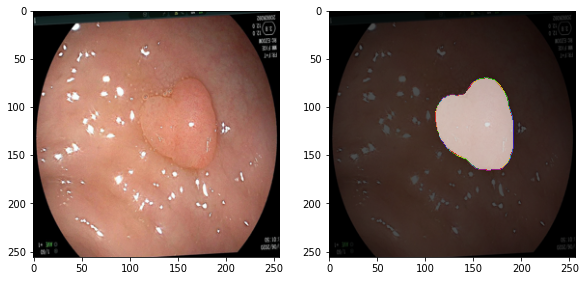

[0 1]


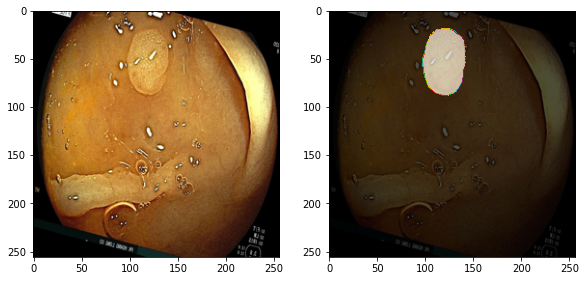

[0 2]


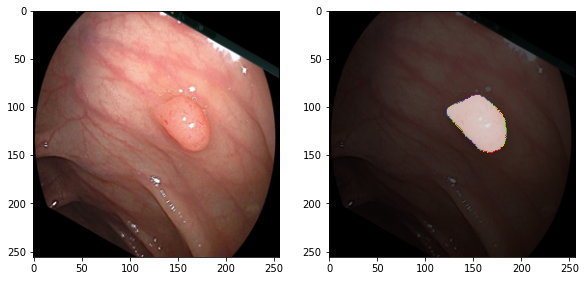

[0 2]


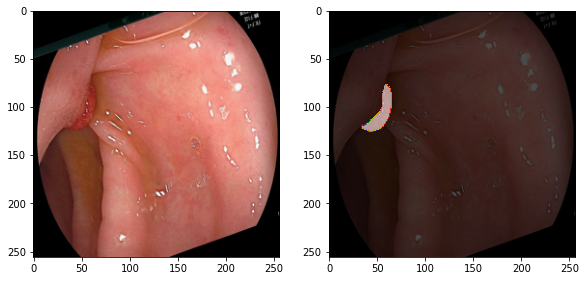

[0 1]


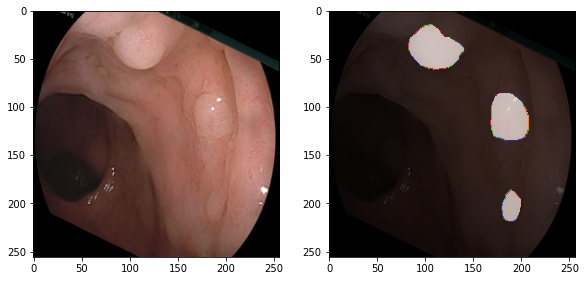

[0 2]


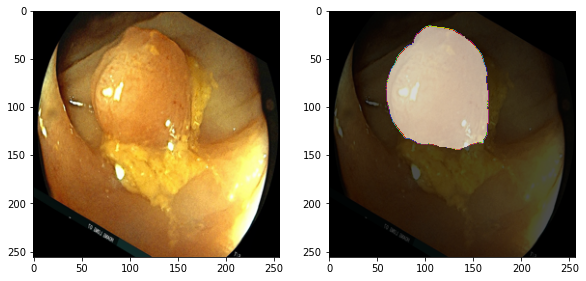

[0 1]


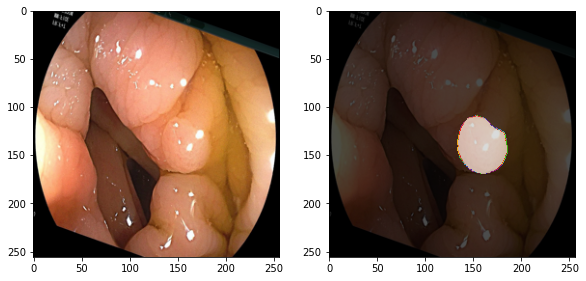

[0 1]


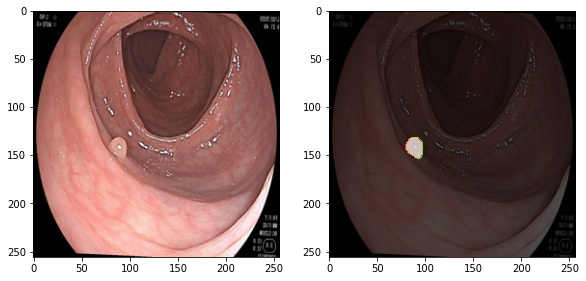

In [8]:
imgs, img_gts = next(iter(dataloader_dict["train"]))

def reverse_transform(inp):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

for i in range(len(imgs)):
    img, img_gt = imgs[i], img_gts[i]
    img = img.numpy().transpose(1, 2, 0)
    img = reverse_transform(img)
    img_gt = img_gt.numpy().squeeze(0)
    print(np.unique(img_gt))
    plt.figure(figsize=(15, 8))
    plt.axis('off')
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(img)
    plt.imshow(img_gt, alpha=0.7, cmap='nipy_spectral')
    plt.show()

# **Model, optimizer, loss**



In [13]:
N_EPOCH = 100

model = NeoUnet()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# summary(model.cuda(), (3, 256, 256))

Using cache found in /root/.cache/torch/hub/PingoLH_Pytorch-HarDNet_master


ImageNet pretrained weights for HarDNet68 is loaded


In [14]:
# all_train_loss = checkpoint['train_loss']
# all_val_loss = checkpoint['val_loss']
# all_train_dice = checkpoint['train_dice']
# all_val_dice = checkpoint['val_dice']

In [18]:
def reverse_transform(inp):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

def show_result(input, y_true, y_pred):
    input = reverse_transform(input.numpy().transpose(1, 2, 0))
    y_true = y_true.numpy().squeeze(0)
    y_pred = torch.argmax(y_pred.permute(1, 2, 0).contiguous(), dim=-1).numpy()
    plt.figure(figsize=(15, 8))
    plt.axis('off')
    plt.subplot(1,3,1)
    plt.imshow(input)
    plt.title("Input")
    plt.subplot(1, 3, 2)
    plt.imshow(input)
    plt.imshow(y_true, alpha=0.3, cmap='nipy_spectral')
    plt.title("target")
    plt.subplot(1, 3, 3)
    plt.imshow(input)
    plt.imshow(y_pred, alpha=0.3, cmap='nipy_spectral')
    plt.title("prediction")
    plt.show()

In [19]:
def train_fn(model, dataloader_dict, optimizer, nEpoch, BATCH_SIZE):
    all_train_loss, all_val_loss, all_train_dice, all_train_iou, all_val_dice, all_val_iou = [], [], [], [], [], []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(0, nEpoch):
        print("Epoch {}/{}".format(epoch+1, nEpoch))
        train_dice_score, train_iou_score = [], []
        val_dice_score, val_iou_score = [], []
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        for phase in ["train", "val"]:
            n_batch = 0
            if phase == "train":
                model.train()
                print("\n###################################")
                print("[INFO] Training network")
                print("Train on {} samples".format(len(dataloader_dict["train"]) * BATCH_SIZE))
            else:
                model.eval()
                print("\n###################################")
                print("[INFO] Evaluation network")
                print("Eval on {} samples".format(len(dataloader_dict["val"]) * BATCH_SIZE))

            for inputs, targets in tqdm(dataloader_dict[phase]): 
                inputs = inputs.to(device).float()
                targets = targets.to(device)

                with torch.set_grad_enabled(phase=="train"):
                    y_pred = model(inputs)
                    loss = multiclass_loss(y_pred, targets)
                    score = iou_dice_score(y_pred.data.cpu(), targets.data.cpu())

                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        epoch_train_loss += loss.item()

                        if n_batch == 99:
                          with torch.no_grad():
                              for i in range(len(inputs)-4):
                                  show_result(inputs[i].cpu(), targets[i].cpu(), y_pred[i].cpu())

                        #####################
                        train_iou_score.append(score[0])
                        train_dice_score.append(score[1])
                        #####################
                    
                    else:
                        epoch_val_loss += loss.item()

                        #####################
                        val_iou_score.append(score[0])
                        val_dice_score.append(score[1])
                        #####################
                n_batch += 1

            if phase == "train":
                print("Training - loss: {:.4f}".format(epoch_train_loss / n_batch))
                print("Average Dice Score: {:.4f}".format(sum(train_dice_score)/ n_batch))
                print("Average IOU Score: {:.4f}".format(sum(train_iou_score) / n_batch))
                print("###################################")

                #####################
                all_train_loss.append(epoch_train_loss / n_batch)
                all_train_dice.append(sum(train_dice_score).item() / n_batch)
                all_train_iou.append(sum(train_iou_score).item() / n_batch)
                #####################
            else:
                print("Evaluation - loss: {:.4f}".format(epoch_val_loss / n_batch))
                print("Average Dice Score: {:.4f}".format(sum(val_dice_score) / n_batch))
                print("Average IOU Score: {:.4f}".format(sum(val_iou_score) / n_batch))
                print("###################################")

                #####################
                all_val_loss.append(epoch_val_loss / n_batch)
                all_val_dice.append(sum(val_dice_score).item() / n_batch)
                all_val_iou.append(sum(val_iou_score).item() / n_batch)
                #####################

        if ((epoch + 1) >= 5) and (((epoch + 1) % 5) == 0):
            torch.save({
                'epoch': epoch+1,
                'train_loss': all_train_loss,
                'val_loss': all_val_loss,
                'train_dice': all_train_dice,
                'val_dice': all_val_dice,
                'train_iou': all_train_dice,
                'val_iou': all_val_dice,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, "/content/drive/MyDrive/Neo-Unet/weights/neounet_weights_{}.pth.tar".format(epoch+1))
            ##################### 
        if ((epoch+1) >= 5) and (((epoch+1) % 5) == 0):
            range_x = np.arange(epoch+1)
            plt.figure()
            plt.plot(range_x, all_train_loss, label="train_loss")
            plt.plot(range_x, all_val_loss, label="val_loss")
            plt.title("LOSS")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.grid()
            plt.legend()
            plt.savefig("/content/drive/MyDrive/Neo-Unet/visualize/loss_{}.png".format(epoch+1))

            plt.figure()
            plt.plot(range_x, all_train_dice, label="train_dice")
            plt.plot(range_x, all_val_dice, label="val_dice")
            plt.title("DICE")
            plt.xlabel("Epoch #")
            plt.ylabel("Dice score")
            plt.grid()
            plt.legend()
            plt.savefig("/content/drive/MyDrive/Neo-Unet/visualize/dice_score_{}.png".format(epoch+1))

            plt.figure()
            plt.plot(range_x, all_train_iou, label="train_iou")
            plt.plot(range_x, all_val_iou, label="val_iou")
            plt.title("IOU")
            plt.xlabel("Epoch #")
            plt.ylabel("Iou score")
            plt.grid()
            plt.legend()
            plt.savefig("/content/drive/MyDrive/Neo-Unet/visualize/iou_score_{}.png".format(epoch+1))
        #####################

In [1]:
train_fn(model, dataloader_dict, optimizer, N_EPOCH, BATCH_SIZE)

NameError: ignored

In [ ]:
import torch
checkpoint = torch.load("/content/drive/MyDrive/Neo-Unet/out/weights/neounet_weights_135.pth.tar")
model = NeoUnet()
model.cuda()
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
from utils.preprocess import preprocess

In [ ]:
model.eval()

In [ ]:
te_paths.sort()

In [ ]:
te_paths

In [ ]:
np.zeros((256, 256, 3)).shape

In [ ]:
import cv2

def process_output(out, path):
    pred = torch.permute(out.cpu(), (1, 2, 0)).contiguous().numpy()
    new_pred = np.zeros((256, 256, 3), dtype=np.uint8) # Blue Green Red
    for i in range (0, 256):
      for j in range (0, 256):
        if pred[i][j][0] >= 0.5 and pred[i][j][1] >= 0.5:
          if (pred[i][j][0] > pred[i][j][1]):
            new_pred[i][j][1] = 255
          else:
            new_pred[i][j][2] = 255
        elif pred[i][j][0] >= 0.5 and pred[i][j][1] < 0.5:
          new_pred[i][j][1] = 255
          new_pred[i][j][2] = 0
        elif pred[i][j][0] < 0.5 and pred[i][j][1] >= 0.5:
          new_pred[i][j][1] = 0
          new_pred[i][j][2] = 255
          
    cv2.imwrite('/content/drive/MyDrive/output/{}.png'.format(path.split('/')[-1].split('.')[0]), new_pred)

def show_result(input, out):
    input = input.squeeze(0)
    input = input.cpu().numpy().transpose(1, 2, 0)
    input = reverse_transform(input)
    pred = torch.permute(out.cpu(), (1, 2, 0)).contiguous().numpy()
    pred[pred < 0.5] = 0
    pred1 = pred[:, :, 0].squeeze()
    pred2 = pred[:, :, 1].squeeze()
    pred1[pred1 >= 0.5] = 1
    pred2[pred2 >= 0.5] = 2
    pred = cv2.bitwise_or(pred1, pred2)
    plt.figure(figsize=(15, 8))
    plt.axis('off')
    plt.subplot(1,2,1)
    plt.imshow(input)
    plt.title("Input")
    plt.subplot(1, 2, 2)
    plt.imshow(input)
    plt.imshow(pred, alpha=0.6, cmap='nipy_spectral')
    plt.title("prediction")
    plt.show()
    
for i, img_path in enumerate(te_paths):
    img = preprocess(img_path, input_size=(256, 256))
    img = img.unsqueeze(0)
    img = img.cuda()
    img_pred = model(img)
    process_output(img_pred[0].detach(), img_path)
    # show_result(img, img_pred[0].detach())

In [ ]:
len(os.listdir('/content/drive/MyDrive/output'))

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 0] = 255
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    ## mask --> string
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r

MASK_DIR_PATH = '/content/drive/MyDrive/output' # change this to the path to your output mask folder
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'/content/drive/MyDrive/submit3.csv', index=False)